# **Boat prices prediction**
---
Summary: This notebook aims to show a boat prices prediction study, using Regression Models, such as Random Forest and Multilinear Regression. First, an Exploratory Data Analysis (EDA) was proposed, then a Feature Selection process was conducted, before applying the regressor models; finally, a cross-validation study was performed, obtaining almost 10% mean squared error (MSE) score, and 91% $R^2$ score.

**Giancarllo Saidel Canaver**

LinkedIn: *https://www.linkedin.com/in/giancarllocanaver/*

---

## **Read the Dataset**

The Dataset related to Boat informations was obtained in Kaggle website, from Mexwell profile, in the following url: *https://www.kaggle.com/datasets/mexwell/boat-price-prediction*

For reading the Dataset, *Pandas* library is very useful when working with '.csv' files!

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('Boats_Cleaned_dataset.csv', sep=',')
df.head()

,Unnamed: 0,id,type,boatClass,make,model,year,condition,length_ft,beam_ft,dryWeight_lb,hullMaterial,fuelType,numEngines,totalHP,maxEngineYear,minEngineYear,engineCategory,price,sellerId,city,state,zip,created_date,created_month,created_year
0,1,7252689,power,power-center,Aquasport,210 CC,1992,used,21.0,8.50,3000.0,fiberglass,gasoline,1,150.0,NaN,NaN,outboard-4s,16500.0,217053,Englewood,FL,34224,2019-10-16,10,2019
1,3,7228300,power,power-sportcruiser,Formula,400 Super Sport,2018,used,40.0,11.00,16100.0,fiberglass,diesel,2,800.0,2018.0,2018.0,inboard-outboard,539000.0,44260,Harsens Island,MI,48028,2019-09-24,9,2019
2,5,7271336,power,power-deck,Bayliner,Element 180,2020,new,18.0,7.42,2000.0,fiberglass,gasoline,1,75.0,2019.0,2019.0,outboard-4s,26995.0,220570,Marietta,OH,45750,2019-11-02,11,2019
3,6,7222952,power,power-expresscruiser,Regal,32 Express,2015,used,32.0,10.33,12650.0,fiberglass,gasoline,2,600.0,NaN,NaN,multiple,169995.0,34834,North Charleston,SC,29405,2019-09-19,9,2019
4,8,6824832,power,power-aft,Carver,440 Aft Cabin Motor Yacht,1994,used,44.0,15.00,32000.0,fiberglass,diesel,2,700.0,1994.0,1994.0,inboard,109900.0,17942,Middle River,MD,21220,2018-08-29,8,2018


## **Cleaning process**
After reading the dataset, a nice practice before beggining the analysis is cleaning the dataset!

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18903 entries, 0 to 18902
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      18903 non-null  int64  
 1   id              18903 non-null  int64  
 2   type            18903 non-null  object 
 3   boatClass       18903 non-null  object 
 4   make            18903 non-null  object 
 5   model           18868 non-null  object 
 6   year            18903 non-null  int64  
 7   condition       18903 non-null  object 
 8   length_ft       18903 non-null  float64
 9   beam_ft         12399 non-null  float64
 10  dryWeight_lb    7094 non-null   float64
 11  hullMaterial    18903 non-null  object 
 12  fuelType        15951 non-null  object 
 13  numEngines      18903 non-null  int64  
 14  totalHP         18055 non-null  float64
 15  maxEngineYear   2205 non-null   float64
 16  minEngineYear   2174 non-null   float64
 17  engineCategory  8410 non-null  

Observing the dataset, it is clear that there are many columns with missing values, which could prejudice further analysis, of the performance of ML models.

There are many ways for dealing with missing values in the datasets, such as filling them with the mode or mean values, or more complex forms, like KNNs or MICE. For a first attempt, we are going to eliminate them and work with the rest.

In [4]:
df.dropna(inplace=True)
print('Length of the DataFrame: ', len(df))

Length of the DataFrame:  1074


In [5]:
df.drop(columns=['Unnamed: 0', 'id'], inplace=True)

## **Exploratory Data Analysis (EDA) - Numerical Variables**
Better results for numerical targets in regression models are obtained using numerical features, so, as the main objective of this project is creating a model that could predict the boat prices, we are going first to select possible numerical features for the prediction.

In [6]:
numerical_columns = [
    "year",
    "length_ft",
    "beam_ft",
    "dryWeight_lb",
    "numEngines",
    "totalHP",
    "maxEngineYear",
    "minEngineYear",
    "price",
    "sellerId",
    "created_month",
    "created_year",
]

For a first step, we will take a look at the values of the columns.

In [7]:
import seaborn as sns
from matplotlib import pyplot as plt

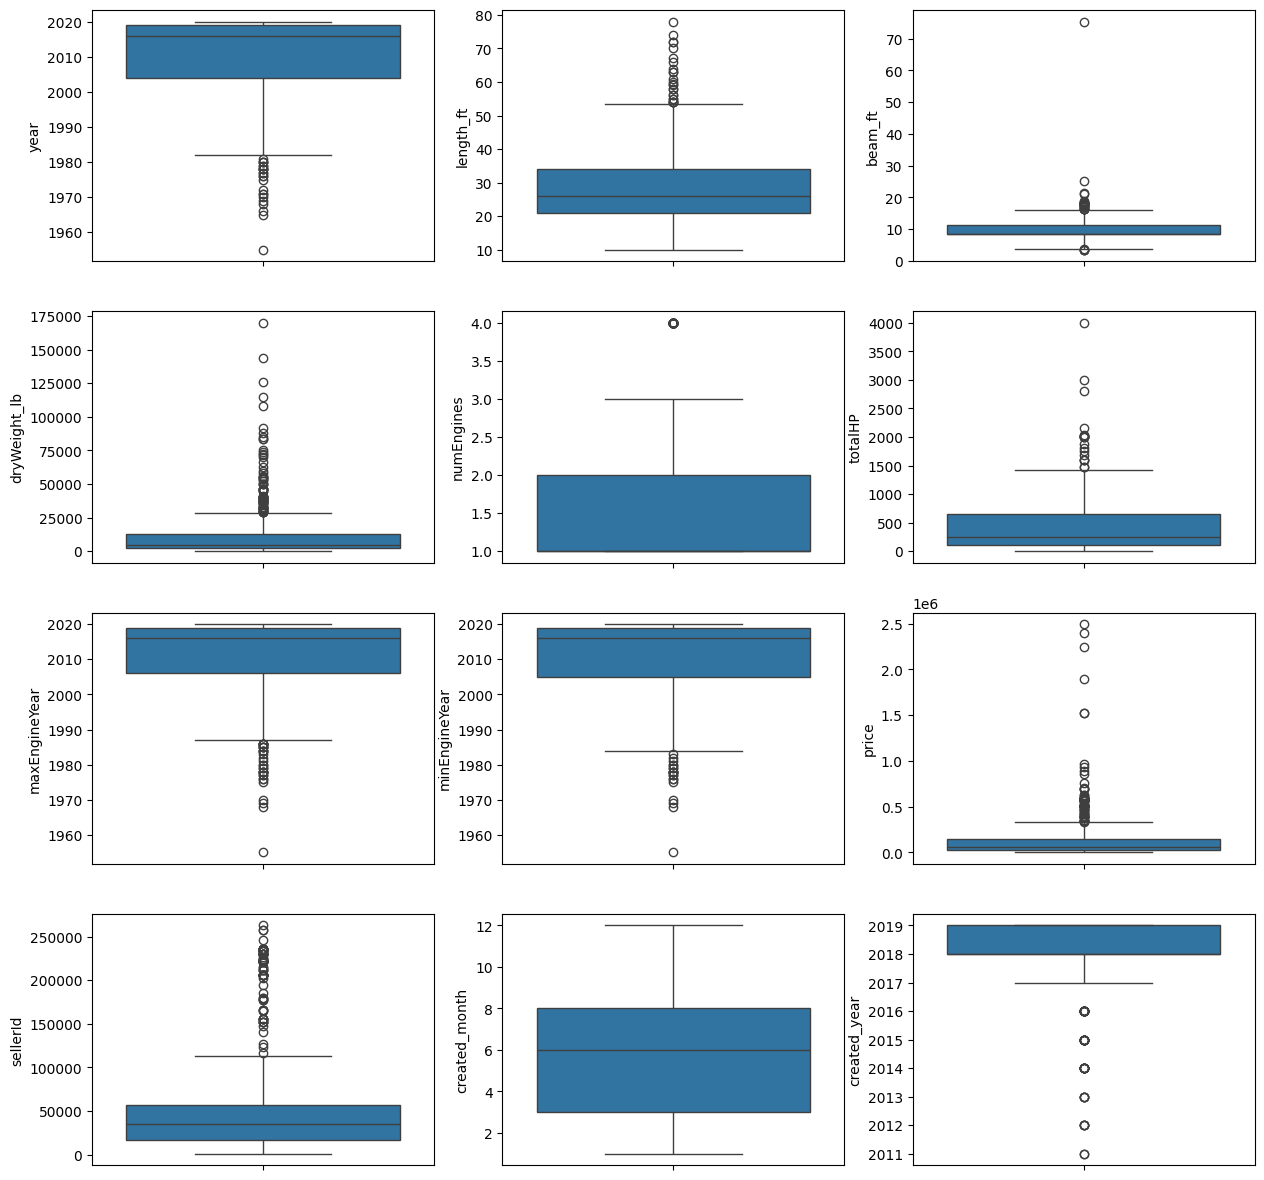

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,15))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.boxplot(df[col], ax=axes[i])

Now, let us observe the distribution of the values, using the violin distribution plots!

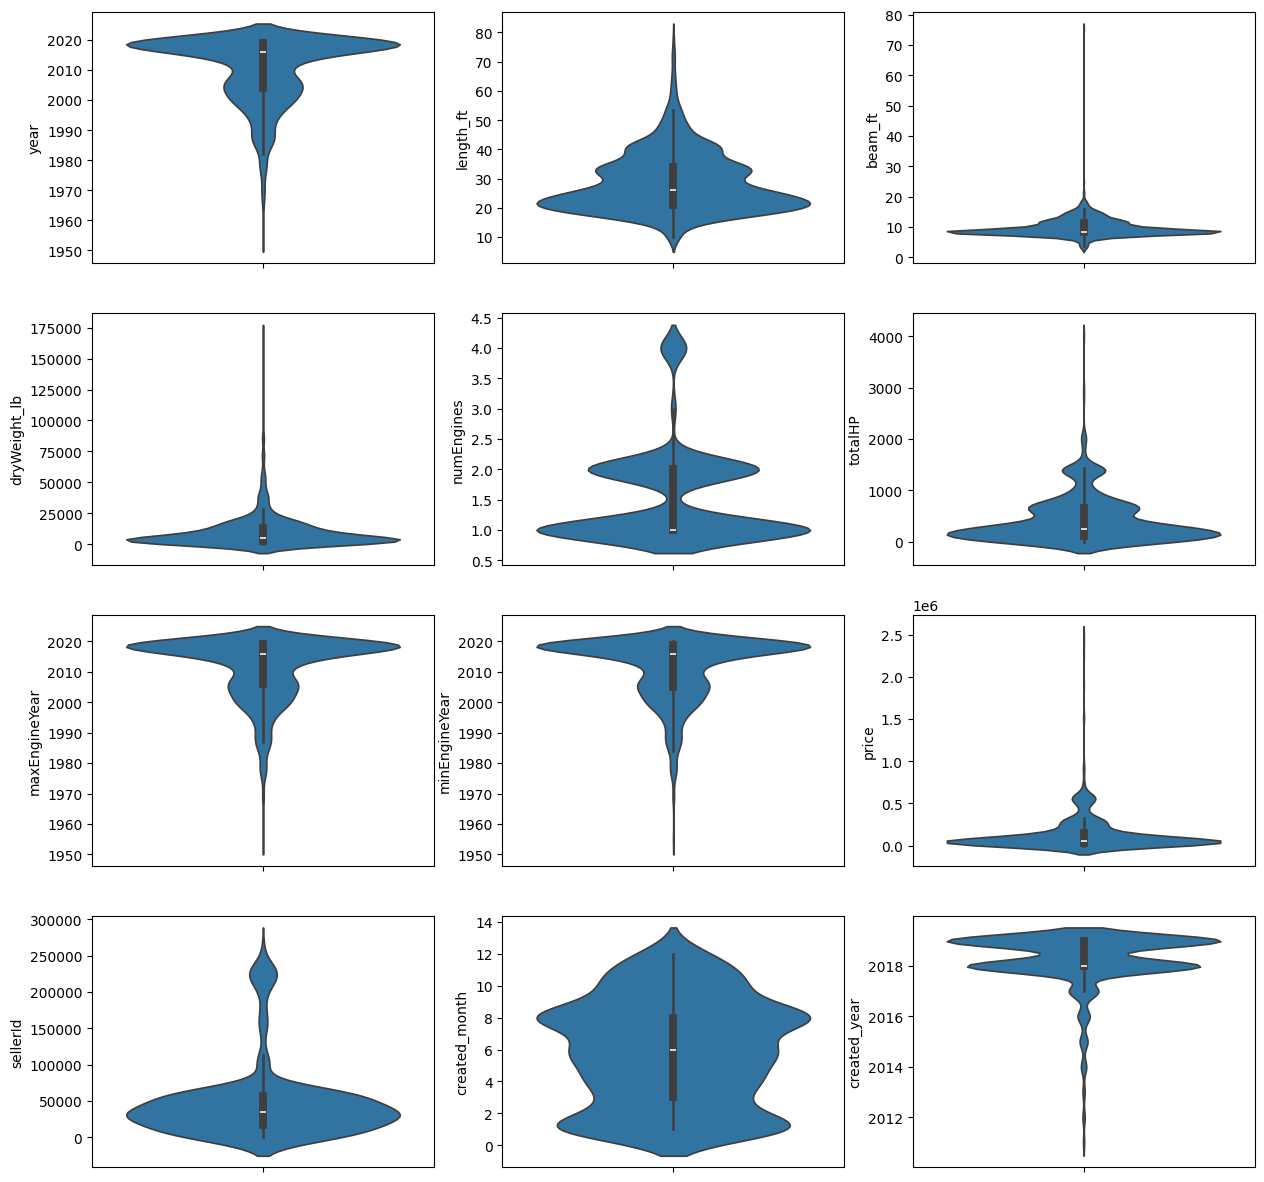

In [9]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,15))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.violinplot(df[col], ax=axes[i])

Looking at the last box-plot graphs, it is possible to observe that most values are consistent with each feature's meaning.

Comparing the box-plot graphs with the violin plots, we can also realize a considerable number of possible outliers in these columns, such as 'numEngines' and 'sellerId'. Hence, we are going to cut just the values that represent less than 5% of the length of the column.

Therefore, we can apply the following procedure:

In [10]:
def calculate_porcentage_of_possible_outliers(col: str) -> float:
    """
    Method responsible for calculating the porcentage
    of possible outliers in the column.

    :param col: column of the dataframe
    ...
    :return: porcentage of possible outliers
    """
    return len(
        df[
            df[col]
            > (
                df[col].quantile(0.75)
                + (1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))
            )
        ]
    ) / len(df)

columns_to_remove_outliers = [
    col
    for col in numerical_columns
    if calculate_porcentage_of_possible_outliers(col) < 0.05
]
columns_to_remove_outliers

['year',
 'length_ft',
 'beam_ft',
 'totalHP',
 'maxEngineYear',
 'minEngineYear',
 'created_month',
 'created_year']

Removing the outliers from the columns.

In [11]:
def remove_outliers(data: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    Method responsible for removing outliers in the
    DataSet.

    :param data: DataFrame used
    :param column: column of analysis
    ...
    :return: new DataFrame
    """
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)

    iql = q3 - q1
    lower_limit = q1 - 1.5 * iql
    upper_limit = q3 + 1.5 * iql

    selection = (data[column] >= lower_limit) & (data[column] <= upper_limit)

    return data[selection]


for col in columns_to_remove_outliers:
    df = remove_outliers(df, col)

print('Final length of the DataFrame: ', len(df))

Final length of the DataFrame:  855


After removing the outliers, we observed that the size of the DataSet has decreased by more than 30%! So, to prevent overfitting possible regression models, a good way is to select some features, using a feature selection process.

## **Feature Ranking - Numerical variables**
For this first selection, we are going to observe first the Q-Q plots of the numerical features to decide if is better to use linear or non-linear techniques.

The feature ranking process will be done by obtaining a rank of the correlation values of the features with the target variable, 'price'.

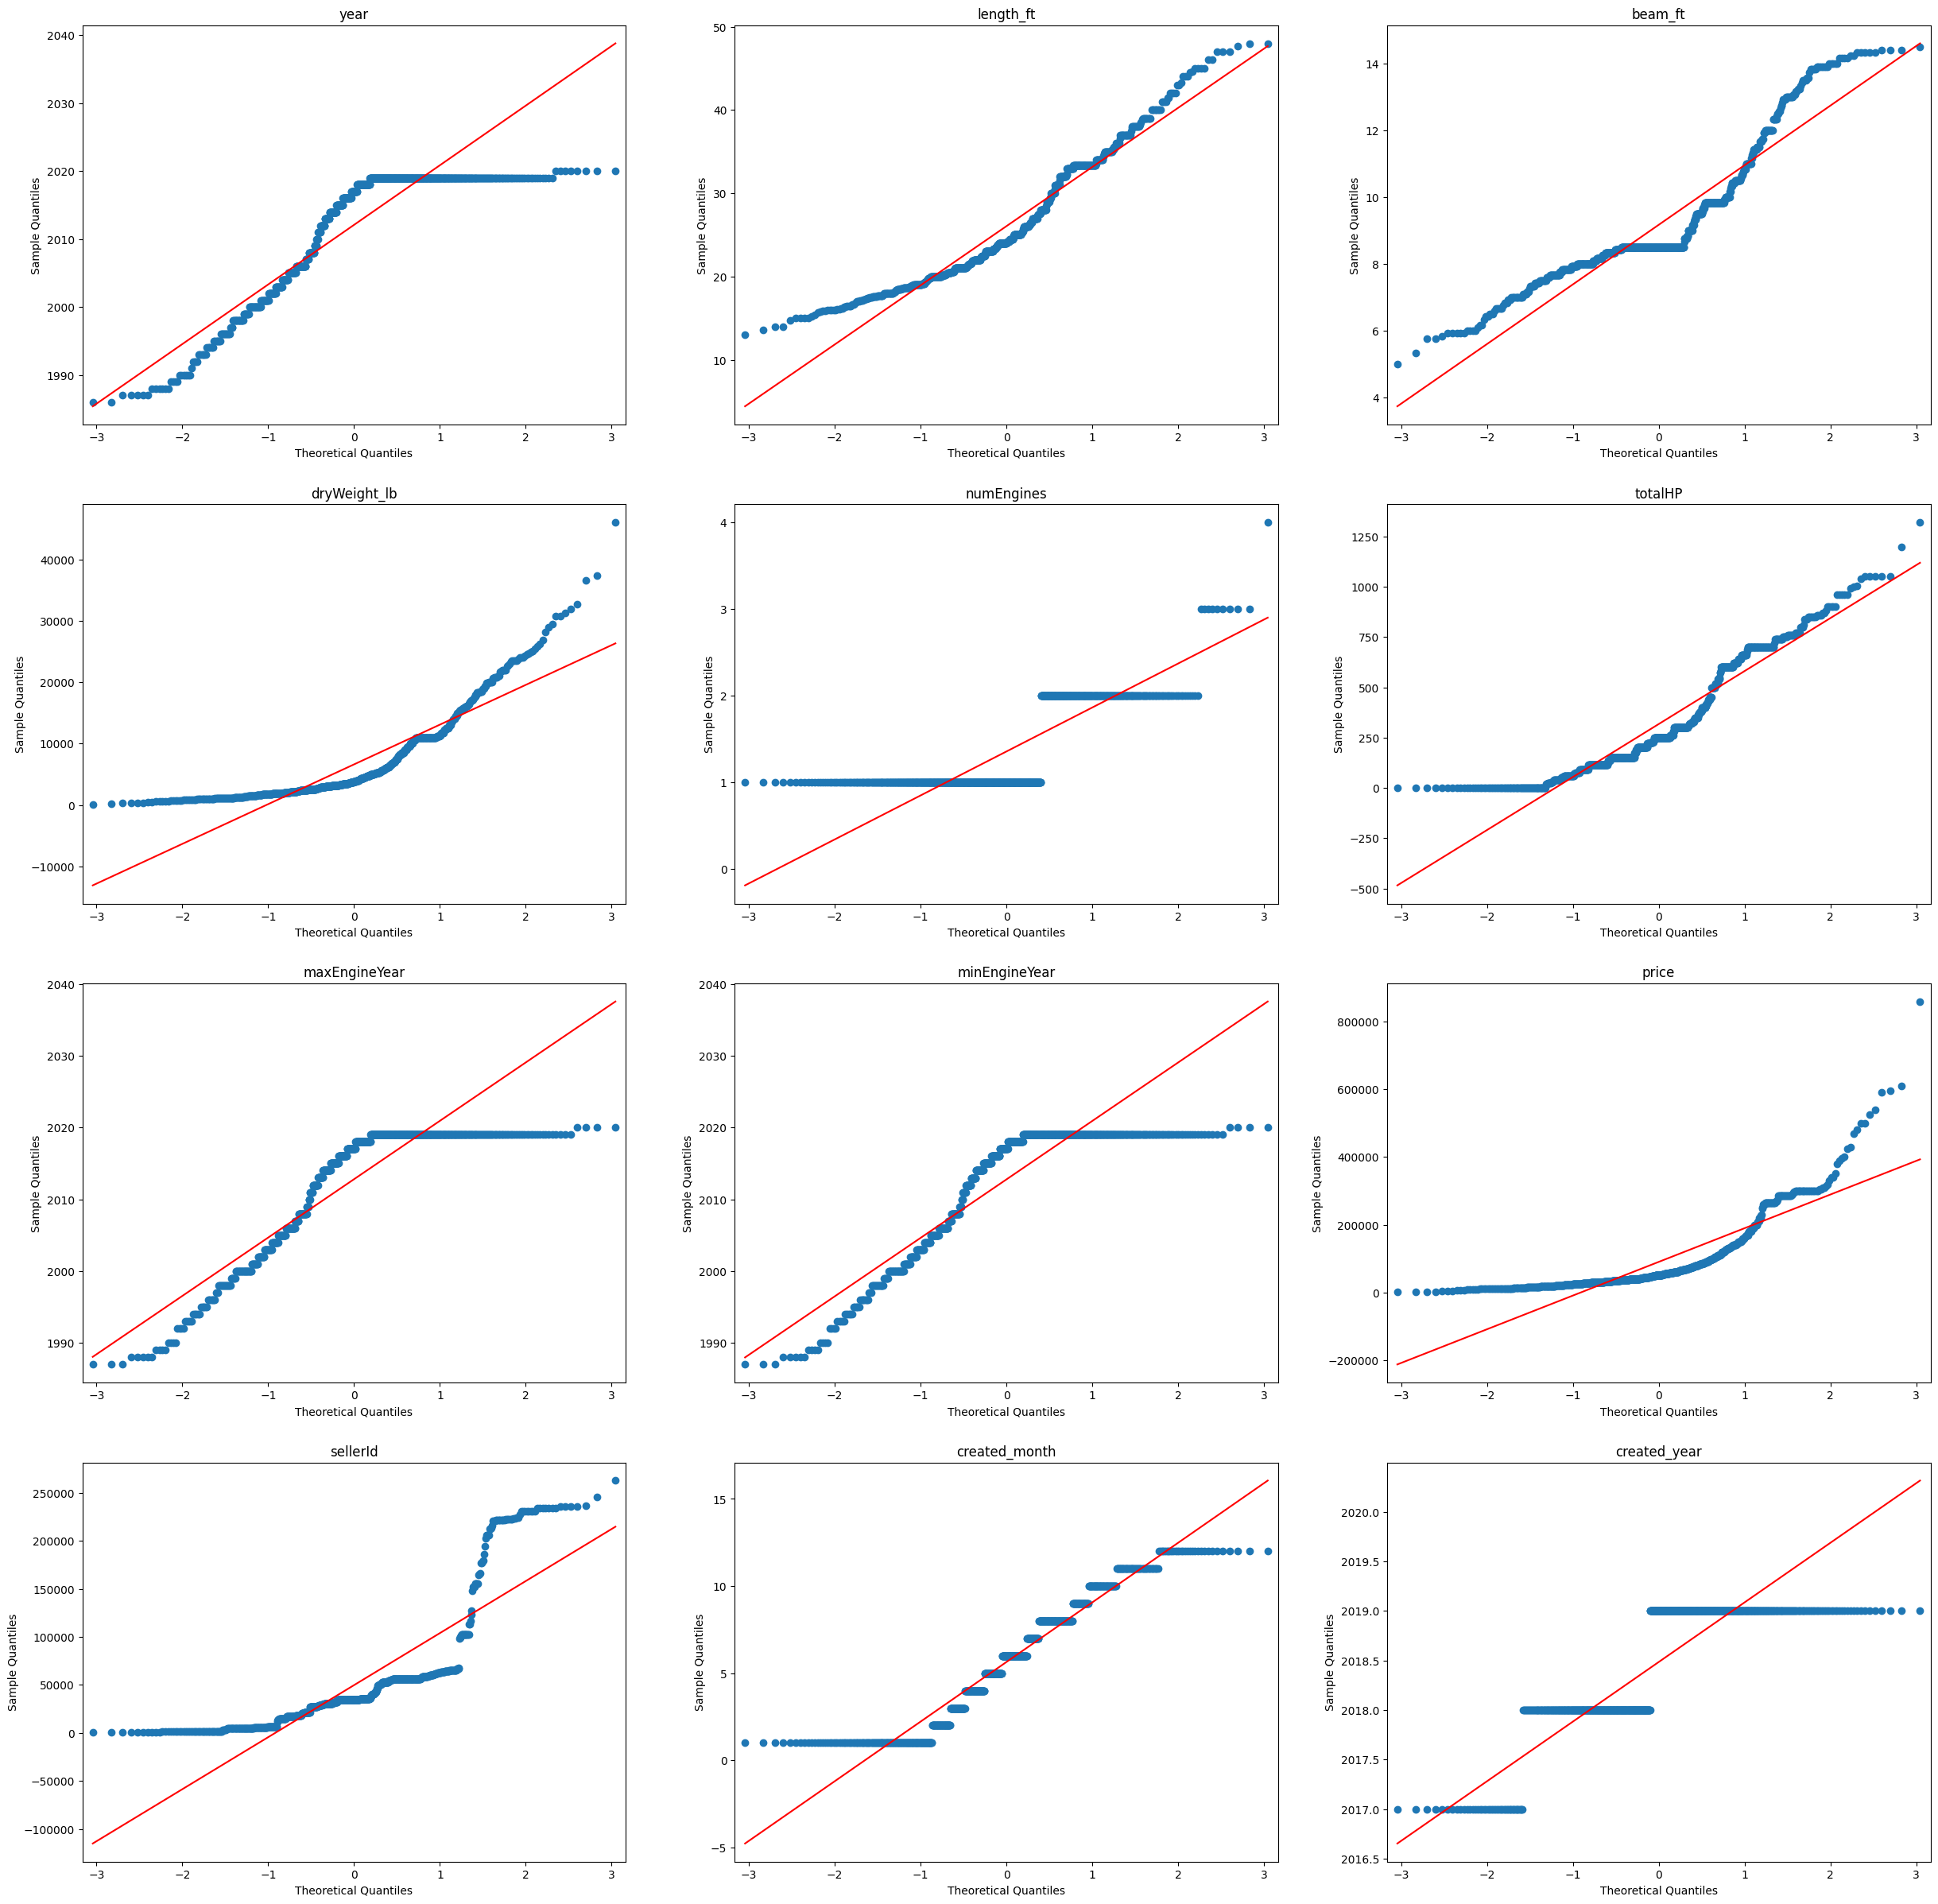

In [12]:
from statsmodels.graphics.gofplots import qqplot

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(30, 30))
axs = axs.flatten()

for i, col in enumerate(numerical_columns):
    qqplot(df[col], ax=axs[i], line='s')
    axs[i].set(title=col)

Observing the Q-Q plots above, we can conclude that just three columns ('length_ft', 'beam_ft', and 'totalHP') seem to be normal, as their distributions are close to the red spline. So, just these features could be applied to a feature selection using Pearson's correlation values with the target feature, as this method is preferred for normal distributions. Therefore, another method must be applied if the intention is to use a unique form for all features.

A method that considers non-linearities with the target is Spearman; otherwise, we are going to use the $\phi_k$ correlation coefficient with the target for selecting those features, as this method is more robust than Spearman.

So, the first step is to measure the correlation coefficient and the p-values with the significance values.

In [13]:
df_numerical_inputs = df[numerical_columns].drop(columns='price')
df_target = df[['price']]

In [14]:
import phik
from tqdm import tqdm

phi_k_numerical_results = [
    (
        column,
        phik.phik_from_array(
            df_numerical_inputs[column],
            df_target.values.reshape(-1,)
        ),        
        phik.significance_from_array(
            df_numerical_inputs[column],
            df_target.values.reshape(-1,)
        )
    )
    for column in tqdm(df_numerical_inputs.columns)
]
phi_k_numerical_results = [
    (feat, corr, sig[0], sig[1])
    for feat, corr, sig in phi_k_numerical_results
]

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [01:19<00:00,  7.24s/it]


In [15]:
corr_results_first = pd.DataFrame(phi_k_numerical_results, columns=['feature', 'corr', 'p-value', 'significance'])
corr_results_first.sort_values(by='corr', ascending=False, inplace=True)
corr_results_first

,feature,corr,p-value,significance
1,length_ft,0.998680,3.352671e-25,10.304768
3,dryWeight_lb,0.998392,3.705675e-30,11.350058
2,beam_ft,0.919635,4.968462e-23,9.812605
9,created_month,0.777610,8.915797e-24,9.984434
5,totalHP,0.657243,1.432161e-24,10.164211
4,numEngines,0.639210,3.001983e-20,9.144260
0,year,0.000000,2.836527e-15,7.811012
6,maxEngineYear,0.000000,8.339877e-15,7.673936
7,minEngineYear,0.000000,1.634737e-14,7.587178
8,sellerId,0.000000,4.702199e-18,8.581010


After obtaining the $\phi_k$ correlation values with the target, we can observe that 'length_ft', 'dryWeight_lb' and 'beam_ft' obtained the best correlation coefficients, with the highest significance values. Thus, we can use this ranking in the model creation, by increasing one feature per time and obtaining the model scores.

## **Regression models appliance - numerical variables**
For this first regression model, we are going to use the LinearRegression, as it is the less computationally expensive model. The features will be increased one by one, in an iterative process. Many models will be built in a cross-validation process. After building the models, the mean and standard deviation of the MSE (mean squared error) values will be used for evaluating the model with each feature increment.

### *LinearRegression model*

In [16]:
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression

Before building the models, a standard scaler process of the target values is mandatory.

In [17]:
sc_instance = StandardScaler()
y_first = sc_instance.fit_transform(df_target.values)

Now, it is possible to build, execute the training step, and evaluate the model.

In [18]:
first_att_results_Ln_Reg = list()
features = list()

cv = KFold(n_splits=10, shuffle=True, random_state=0)
for i, feat in enumerate(
    df_numerical_inputs[corr_results_first["feature"].to_list()].columns
):
    features.append(feat)

    sc_instance = StandardScaler()
    feat_incl = sc_instance.fit_transform(
        df_numerical_inputs[feat].values.reshape(-1, 1)
    )

    if not i:
        x_first = feat_incl.copy()
    else:
        x_first = np.concatenate((x_first, feat_incl), axis=1)

    scores = cross_val_score(
        LinearRegression(),
        x_first,
        y_first,
        cv=cv,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        verbose=10,
    )
    first_att_results_Ln_Reg.append(
        (abs(scores.mean()), scores.std(), len(features.copy()), feat)
    )

results_first_Ln_Reg = pd.DataFrame(
    first_att_results_Ln_Reg, columns=["mse", "std", "number of features", "feature inclusion"]
)
results_first_Ln_Reg

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0115203857421875s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.007441282272338867s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 

,mse,std,number of features,feature inclusion
0,0.565945,0.199993,1,length_ft
1,0.569903,0.198568,2,dryWeight_lb
2,0.497860,0.185452,3,beam_ft
3,0.495250,0.189148,4,created_month
4,0.490396,0.177300,5,totalHP
5,0.475562,0.185258,6,numEngines
6,0.282401,0.131230,7,year
7,0.281227,0.129218,8,maxEngineYear
8,0.278214,0.128422,9,minEngineYear
9,0.280982,0.133761,10,sellerId


<Axes: xlabel='number of features', ylabel='mse'>

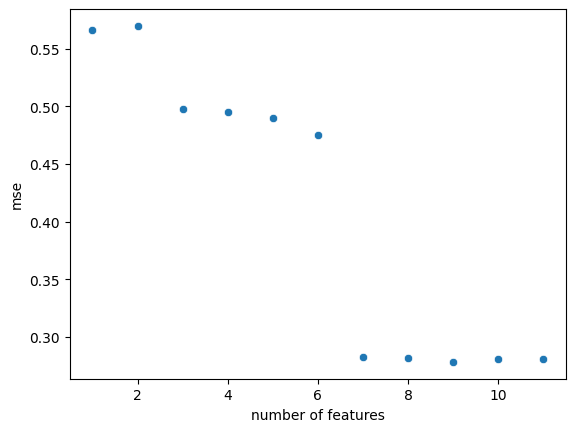

In [19]:
sns.scatterplot(results_first_Ln_Reg, x="number of features", y="mse")

Looking at the graph above, after the inclusion of 8 features, the MSE value does not decrease considerably; also, if paying attention to the standard deviation value, after 9 features, it starts to increase, which is unfavorable. So, the best MSE value obtained is 0.281227 with a standard deviation of 0.129218.

Now, let us use RandomForest and see if we can get better results!

### *RandomForest model*

In [35]:
from sklearn.ensemble import RandomForestRegressor

first_att_results_RF = list()
features = list()

cv = KFold(n_splits=10, shuffle=True, random_state=0)
for i, feat in enumerate(
    df_numerical_inputs[corr_results_first["feature"].to_list()].columns
):
    features.append(feat)

    sc_instance = StandardScaler()
    feat_incl = sc_instance.fit_transform(
        df_numerical_inputs[feat].values.reshape(-1, 1)
    )

    if not i:
        x_first = feat_incl.copy()
    else:
        x_first = np.concatenate((x_first, feat_incl), axis=1)

    scores_RF_numerical = cross_val_score(
        RandomForestRegressor(n_estimators=300, random_state=0),
        x_first,
        y_first,
        cv=cv,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        verbose=10,
    )
    first_att_results_RF.append(
        (
            abs(scores_RF_numerical.mean()),
            scores_RF_numerical.std(),
            len(features.copy()),
            feat,
        )
    )

results_first_RF = pd.DataFrame(
    first_att_results_RF, columns=["mse", "std", "number of features", "feature inclusion"]
)
results_first_RF

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    5.8s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    5.8s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    4.0s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    4.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    3.7s remaining: 

,mse,std,number of features,feature inclusion
0,0.489392,0.275032,1,length_ft
1,0.438592,0.178839,2,dryWeight_lb
2,0.329369,0.161173,3,beam_ft
3,0.346853,0.191292,4,created_month
4,0.294983,0.189776,5,totalHP
5,0.286772,0.182965,6,numEngines
6,0.115803,0.068662,7,year
7,0.114960,0.065840,8,maxEngineYear
8,0.115735,0.067379,9,minEngineYear
9,0.111069,0.061228,10,sellerId


<Axes: xlabel='number of features', ylabel='mse'>

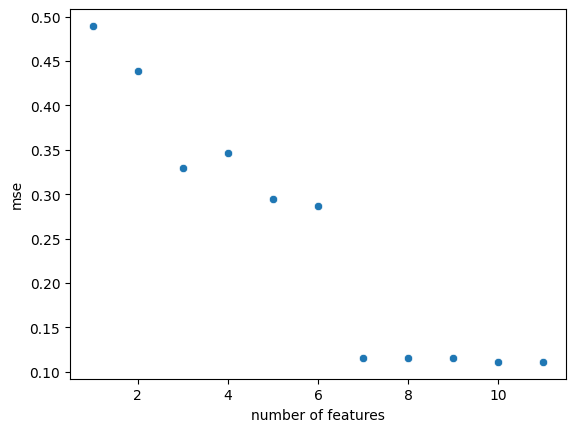

In [21]:
sns.scatterplot(results_first_RF, x="number of features", y="mse")

Now, observing the Random Forest regression cross-validation model, we can see that 8 features are enough to predict the price value, as the MSE did not decrease considerably after these 8 features.

Comparing both regression results, we can conclude that the Random Forest model obtained a lower MSE error than the Linear Model; it is also possible to observe that the Random Forest got less variability in the cross-validation process when compared to the Linear Model, which is favorable. So, the Random Forest model got better results.

Before taking these 8 variables as the main numerical variables, it is nice to look at the correlations between these features!

In [22]:
import phik
from tqdm import tqdm

phi_k_matrix = df_numerical_inputs.phik_matrix()
significance_matrix = df_numerical_inputs.significance_matrix()

interval columns not set, guessing: ['year', 'length_ft', 'beam_ft', 'dryWeight_lb', 'numEngines', 'totalHP', 'maxEngineYear', 'minEngineYear', 'sellerId', 'created_month', 'created_year']


interval columns not set, guessing: ['year', 'length_ft', 'beam_ft', 'dryWeight_lb', 'numEngines', 'totalHP', 'maxEngineYear', 'minEngineYear', 'sellerId', 'created_month', 'created_year']


<Axes: >

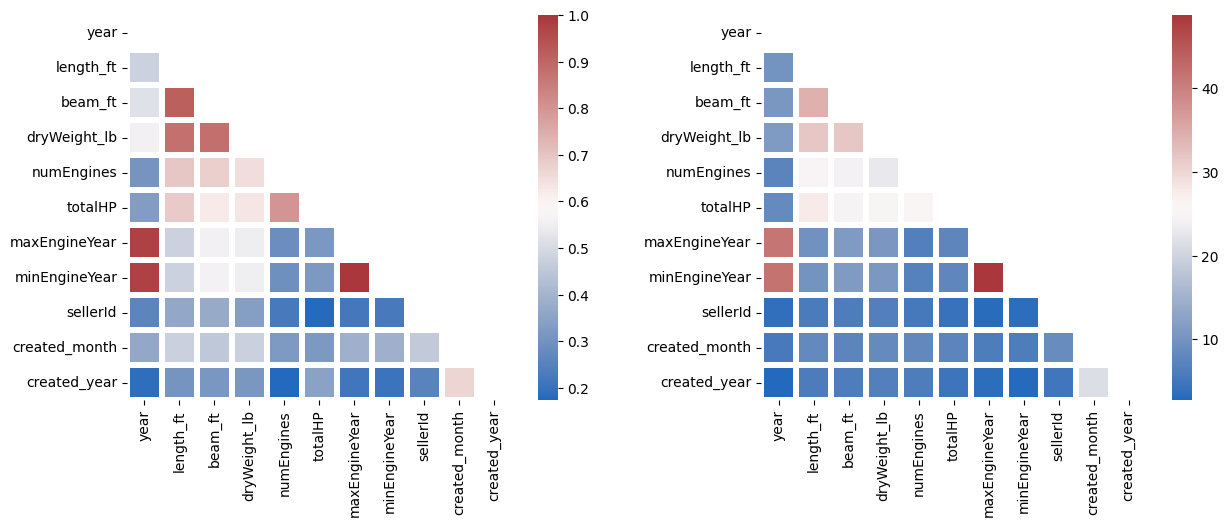

In [23]:
import numpy as np

mask_phi_k = np.triu(np.ones_like(phi_k_matrix))
mask_signif = np.triu(np.ones_like(significance_matrix))

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

sns.heatmap(
    phi_k_matrix,
    cmap='vlag',
    square=True,
    linewidths=4,
    mask=mask_phi_k,
    vmax=1.0,
    ax=axs[0]
)

sns.heatmap(
    significance_matrix,
    cmap='vlag',
    square=True,
    linewidths=4,
    mask=mask_signif,
    ax=axs[1]
)

Looking at the correlation matrix, we can realize that most of the selected features have low to medium correlation values with each other, with the exception to the 'maxEngineYear' with 'year'; so, to reduce the possibility of collinearity, we can remove this last feature!

Therefore, the selected numerical features are:

In [24]:
df_inputs_first = df_numerical_inputs[
    [
        "length_ft",
        "dryWeight_lb",
        "beam_ft",
        "year",
        "numEngines",
        "totalHP",
        "created_month",
    ]
]

Now, we can focus on applying categorical features to the Random Forest model and see if we can improve the prediction model!

## **Feature ranking - Categorical Variables**
As done with the numerical variables, a feature ranking can also be prepared using the $\phi_k$ coefficient.

In [25]:
categorical_columns = list(set(df.columns) - set(numerical_columns))
df_categorical_inputs = df[categorical_columns]

In [26]:
import phik
from tqdm import tqdm

phi_k_cat_results = [
    (
        column,
        phik.phik_from_array(
            df_categorical_inputs[column],
            df_target.values.reshape(-1,)
        ),        
        phik.significance_from_array(
            df_categorical_inputs[column],
            df_target.values.reshape(-1,)
        )
    )
    for column in tqdm(df_categorical_inputs.columns)
]
phi_k_cat_results = [
    (feat, corr, sig[0], sig[1])
    for feat, corr, sig in phi_k_cat_results
]

100%|██████████| 12/12 [01:58<00:00,  9.86s/it]


In [27]:
corr_cat_results = pd.DataFrame(
    phi_k_cat_results, columns=["feature", "corr", "p-value", "significance"]
)
corr_cat_results.sort_values(by="corr", ascending=False, inplace=True)
corr_cat_results

,feature,corr,p-value,significance
8,model,0.999737,7.273855e-39,12.986749
9,condition,0.952232,1.483799e-36,12.573124
5,make,0.945007,5.289007e-26,10.480858
6,engineCategory,0.902028,1.628093e-26,10.591701
2,state,0.821341,9.099506e-16,7.953040
3,fuelType,0.813207,2.058786e-05,4.100781
4,type,0.681558,2.277755e-02,1.999493
0,created_date,0.000000,7.103320e-27,10.669053
1,zip,0.000000,3.006524e-18,8.632300
7,boatClass,0.000000,1.538565e-24,10.157224


Looking at the ranking above, we can realize that 'model' and 'make' have the best correlation values with the target! 

Before joining the numerical features with the categorical, it is nice to observe the correlation between all the possible feature variables, because using the OneHotEncoder technique for encoding categorical variables uses high computational costs!

In [28]:
df_ensemble = pd.concat(
    [df_inputs_first, df_categorical_inputs],
    axis=1
)

In [29]:
phi_k_ensemble_matrix = df_ensemble.phik_matrix();
significance_ensemble_matrix = df_ensemble.significance_matrix();

interval columns not set, guessing: ['length_ft', 'dryWeight_lb', 'beam_ft', 'year', 'numEngines', 'totalHP', 'created_month']


interval columns not set, guessing: ['length_ft', 'dryWeight_lb', 'beam_ft', 'year', 'numEngines', 'totalHP', 'created_month']


Text(0.5, 1.0, 'Significance Value')

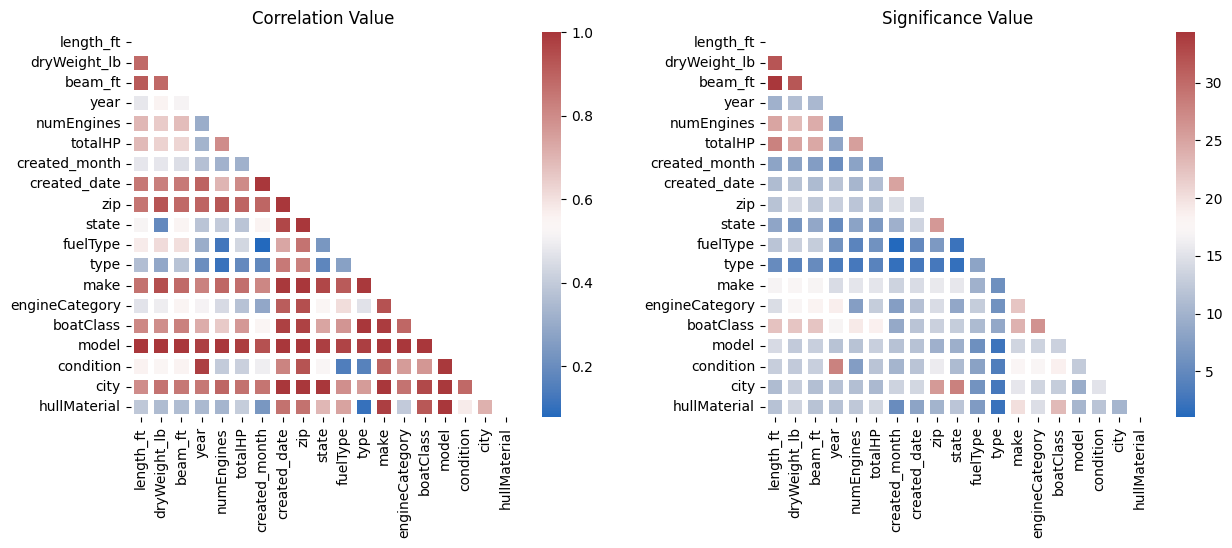

In [30]:
mask_phi_k = np.triu(np.ones_like(phi_k_ensemble_matrix))
mask_signif = np.triu(np.ones_like(significance_ensemble_matrix))

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

sns.heatmap(
    phi_k_ensemble_matrix,
    cmap='vlag',
    square=True,
    linewidths=4,
    mask=mask_phi_k,
    vmax=1.0,
    ax=axs[0]
)
axs[0].set_title("Correlation Value")

sns.heatmap(
    significance_ensemble_matrix,
    cmap='vlag',
    square=True,
    linewidths=4,
    mask=mask_signif,
    ax=axs[1]
)
axs[1].set_title("Significance Value")

We could see in the correlation values above that the categorical features 'model' and 'make' have a substantial correlation with all the other features. However, the other three features in the categorical ranking, 'condition', 'engineCategory', and 'state', have less considerable correlation values!

Hence, as categorical features must be passed into an encoder process, which creates more feature columns and increases the complexity of the model, we can choose just these three features for using with the numerical ones, and see if we can get better MSE results than just using numerical features!

## **Regression models appliance - ensemble features**
We will just use the Random Forest regressor, as we took better results before. The 'OneHotEncoder' will be used as the encoder for the categorical features.

In [31]:
from sklearn.preprocessing import OneHotEncoder

In [36]:
from sklearn.ensemble import RandomForestRegressor

sc_instance = StandardScaler()
x_second = sc_instance.fit_transform(df_inputs_first.values)

second_att_results_rf_reg = list()
features = list()

cv = KFold(n_splits=10, shuffle=True, random_state=0)
for i, feat in tqdm(enumerate(["condition", "engineCategory", "state"])):
    features.append(feat)

    sc_instance = OneHotEncoder(sparse_output=False)
    feat_incl = sc_instance.fit_transform(
        df_categorical_inputs[feat].values.reshape(-1, 1)
    )

    x_second = np.concatenate((x_second, feat_incl), axis=1)

    scores_RF_ensemble = cross_val_score(
        RandomForestRegressor(n_estimators=300, random_state=0),
        x_second,
        y_first,
        cv=cv,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        verbose=10,
    )
    second_att_results_rf_reg.append(
        (
            abs(scores_RF_ensemble.mean()),
            scores_RF_ensemble.std(),
            len(features.copy()),
            feat,
        )
    )

results_second_RF_reg = pd.DataFrame(
    second_att_results_rf_reg,
    columns=["mse", "std", "number of features", "feature inclusion"],
)
results_second_RF_reg

0it [00:00, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    4.6s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    4.6s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.3s finished
1it [00:06,  6.39s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    4.8s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    4.8s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.5s finished
2it [00:13,  6.52s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    6.1s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    6.1s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.3s finished
3it [00:21,

,mse,std,number of features,feature inclusion
0,0.111465,0.069442,1,condition
1,0.110767,0.071936,2,engineCategory
2,0.109965,0.071164,3,state


Increasing the number of features in the model could decrease a bit the MSE mean value along the cross-validation process, but increase the standard deviation value, as we can observe bellow:

In [34]:
regression_compare = [
    results_first_RF.iloc[6,:3].to_list(),
    results_second_RF_reg.iloc[2,:2].to_list()
]
regression_compare[1].append(10)

pd.DataFrame(
    regression_compare,
    columns=['mse', 'std', 'number of features'],
    index=['RF with just numerical features', 'RF with ensemble features']
)

,mse,std,number of features
RF with just numerical features,0.115803,0.068662,7
RF with ensemble features,0.109965,0.071164,10


## **$R^2$ evaluation**
If we take both models and evaluate 20% of the data with the $R^2$ metric, we can observe how well our model are adjusted to the data.

In [39]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [44]:
sc_instance = StandardScaler()
num_values = sc_instance.fit_transform(df_inputs_first.values)

x_num_val, x_num_test, y_num_val, y_num_test = train_test_split(
    num_values, y_first, test_size=0.2,
)
x_ens_val, x_ens_test, y_ens_val, y_ens_test = train_test_split(
    x_second, y_first, test_size=0.2,
)

In [45]:
num_model = RandomForestRegressor(n_estimators=300, random_state=0)
num_model.fit(x_num_val, y_num_val)
r2_num_model = metrics.r2_score(
    y_num_test,
    num_model.predict(x_num_test)
)

ens_model = RandomForestRegressor(n_estimators=300, random_state=0)
ens_model.fit(x_ens_val, y_ens_val)
r2_ens_model = metrics.r2_score(
    y_ens_test,
    ens_model.predict(x_ens_test)
)

c:\Users\miife\miniconda3\envs\regressao\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\miife\miniconda3\envs\regressao\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [46]:
print(" R2 numerical model: ", r2_num_model, "\n", "R2 ensemble model: ", r2_ens_model)

 R2 numerical model:  0.9007070844367755 
 R2 ensemble model:  0.907627652114979


Observing both results, we can see no longer difference between both models; in addition, both models obtained well values, indicating that the models are adjusted to the data!

## **Conclusion**
After making the cross-validation studies with numerical and ensemble features, we can conclude that the Random Forest with the ensemble features got tiny better results than when just working with numerical features. However, the ensemble model includes more complexity when dealing with categorical columns, such as making the model more overfitted to the data, which makes the model with just numerical features a better choice!

Despite the good performance of the suggested models, the database when removing the missing values is not huge, which may bias the prediction of unseen values; for this reason, these models must be tested with more values, by using the initial database and practicing a better treatment in the missing values, or taking new data.